In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# read the csv

In [2]:
credit_frame = pd.read_csv('credit_g_normalized.csv')
col_name = credit_frame.columns
# print(col_name[0:3]) 

In [3]:
columns = credit_frame.shape[1]
num_features = columns -1

x_data = credit_frame.values[:,0:num_features]# dataframe not support slice
y_data = credit_frame.values[:,columns - 1]

x_train, x_test, y_train, y_test = \
        train_test_split(x_data, y_data, test_size=0.2, stratify=y_data, random_state=12)

x_train = pd.DataFrame(x_train)
x_train.columns = col_name[:38]
x_test  = pd.DataFrame(x_test)
x_test.columns = col_name[:38]
y_train = pd.DataFrame(y_train)
y_train.columns = col_name[38:]
y_test  = pd.DataFrame(y_test)
y_test.columns = col_name[38:]
print(y_test)
#y_test.describe()

     RESPONSE
0           1
1           1
2           0
3           0
4           1
..        ...
195         0
196         0
197         1
198         0
199         1

[200 rows x 1 columns]


# Find the processed feature and the target feature

In [4]:
# def preprocess_features(credit_frame):
#     selected_features = credit_frame[
#     ["CHK_ACCT",
#      "DURATION",
#      "HISTORY",
#      "NEW_CAR",
#      "USED_CAR",
#      "EDUCATION",
#      "RETRAINING",
#      "BUSINESS",
#      "RENT",
#      "NUM_CREDITS",
#      "JOB",
#      "NUM_DEPENDENTS"]]
#     processed_features = selected_features.copy()
#     return processed_features

# def preprocess_targets(credit_frame):
#     output_targets = pd.DataFrame()
#     # Scale the target to be a boolean
#     output_targets["RESPONSE"] = (
#     credit_frame["RESPONSE"] )
#     return output_targets

# Split the trainning set and the testing set
   <font size=5>Maybe a valid set should be also included</font>
   <font size=5>emm...sample still too little</font>

In [5]:
# Choose the first 800 (out of 1000) examples for training.
training_examples = x_train
training_targets = y_train
# Choose the last 200 (out of 1000) examples for validation.
validation_examples = x_test
validation_targets = y_test

# # Double-check
# print("Training examples summary:")
# display.display(training_examples.describe())
# print("Validation examples summary:")
# display.display(validation_examples.describe())

# print("Training targets summary:")
# display.display(training_targets.describe())
# print("Validation targets summary:")
# display.display(validation_targets.describe())

# Build the network (DNN)
<font size=5>hidden_units[]</font>


In [6]:
def construct_feature_columns(input_features):
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [7]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    
    # Convert pandas data into a dict of np arrays. it should finish two stpes: 1.to dict 2.to np.arrary
    features = {key:np.array(value) for key,value in dict(features).items()}                                             
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data
    if shuffle:
      ds = ds.shuffle(800)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [13]:
def train_nn_regression_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
  periods = 10
  steps_per_period = steps / periods
  

  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  dnn_regressor = tf.estimator.DNNRegressor(
      feature_columns=construct_feature_columns(training_examples),
      hidden_units=hidden_units,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["RESPONSE"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["RESPONSE"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["RESPONSE"], 
                                                    num_epochs=1, 
                                                    shuffle=False)


  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model.
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )

    training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets)) #trainning mse
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets)) #validation mse
    #print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    
    
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
    
    print(validation_targets)
    print(validation_predictions)
    validation_predictions = [int(item > 1) for item in validation_predictions ]
#     print(validation_targets)
#     print(validation_predictions)
    accuracy = round(accuracy_score(validation_targets, validation_predictions),4)
    recall = round(recall_score(validation_targets, validation_predictions, pos_label=0),4)
    auc = round(roc_auc_score(validation_targets, validation_predictions),4)
    print('acc = {}, re = {}, auc = {}'.format(accuracy,recall,auc))
  print("Model training finished.")


  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
  print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

  return dnn_regressor

Training model...
RMSE (on training data):
  period 00 : 3.27
     RESPONSE
0           1
1           1
2           0
3           0
4           1
..        ...
195         0
196         0
197         1
198         0
199         1

[200 rows x 1 columns]
[3.3285363 5.113664  2.5672734 5.034761  3.03206   3.897485  4.1864085
 3.2451718 3.0897992 3.8437588 2.235757  2.643884  4.4265    4.1963344
 3.742349  2.9790928 3.6408474 5.1647544 2.5095036 6.292909  4.2581344
 3.2361157 4.9567466 2.4735978 2.3027337 3.4340432 5.6014724 3.3740857
 3.6316464 3.32813   2.3261921 4.570173  2.6336815 3.2080357 6.803926
 2.8845074 2.9579499 2.9491513 3.1431935 3.4973633 2.873399  3.155288
 4.8429275 3.806413  4.327474  4.751695  4.574125  2.7935746 2.1127903
 2.8518918 4.923471  3.0568745 2.3066304 3.7267315 2.3458493 2.0777962
 4.531545  2.7535336 6.857515  2.821932  2.6834347 2.5997975 3.90924
 3.5637982 3.7695706 2.520387  2.889455  3.766042  3.5781796 3.170606
 3.0876553 2.0932496 3.1255467 2.2772896 

  period 04 : 2.90
     RESPONSE
0           1
1           1
2           0
3           0
4           1
..        ...
195         0
196         0
197         1
198         0
199         1

[200 rows x 1 columns]
[3.008521  4.630225  2.3106413 4.540473  2.7294226 3.4928274 3.741168
 2.9267416 2.7726622 3.4255514 2.0003958 2.390151  4.0186377 3.750206
 3.3981924 2.6715193 3.301013  4.645549  2.2645884 5.691741  3.8231115
 2.9154005 4.465499  2.2172995 2.064889  3.0710497 5.098716  3.0493383
 3.2722921 2.9989157 2.096078  4.0875463 2.367856  2.8952932 6.182517
 2.6077337 2.6454573 2.6471777 2.8011012 3.1272917 2.606906  2.832572
 4.4124365 3.4409208 3.8846502 4.32273   4.1272764 2.4941072 1.9125718
 2.5849829 4.403243  2.7646208 2.0674753 3.3426275 2.1154165 1.8596696
 4.0541754 2.4783125 6.1925497 2.5129004 2.4115362 2.343871  3.4883394
 3.220603  3.4082975 2.3311377 2.6049547 3.3979483 3.207286  2.8443823
 2.8098707 1.8710374 2.8187513 2.0527658 3.0489874 2.413001  2.063283
 2.6934652 2.

  period 08 : 2.52
     RESPONSE
0           1
1           1
2           0
3           0
4           1
..        ...
195         0
196         0
197         1
198         0
199         1

[200 rows x 1 columns]
[2.6894195 4.1230154 2.0522563 4.0215445 2.4170902 3.08615   3.3051212
 2.6020496 2.4556186 3.0126293 1.7671498 2.1331089 3.5881183 3.3156269
 3.043101  2.365115  2.9525745 4.1311426 2.0198524 5.0748587 3.378043
 2.5941646 3.9713428 1.9628094 1.8287152 2.716685  4.551482  2.722884
 2.9019916 2.6675365 1.8663911 3.609553  2.1033084 2.579398  5.5258627
 2.327586  2.3379333 2.339835  2.4702537 2.7642753 2.3386981 2.511914
 3.94435   3.0706928 3.443198  3.8644702 3.6802204 2.1973693 1.7099179
 2.3117244 3.885615  2.4687526 1.8317288 2.9602687 1.8799847 1.6453618
 3.5829704 2.1982753 5.5108633 2.2126682 2.1319263 2.088723  3.077542
 2.8676364 3.0400836 2.0850208 2.321818  3.0301807 2.8360965 2.5186336
 2.5256603 1.6525029 2.5060985 1.8281926 2.7037685 2.1187847 1.8422173
 2.407046  1

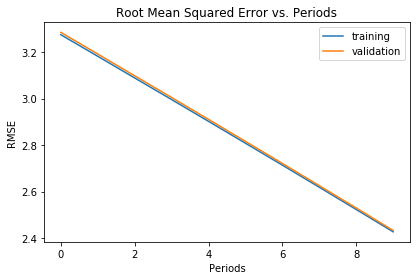

In [14]:
dnn_regressor = train_nn_regression_model(
    learning_rate=0.001,
    steps=2000,
    batch_size=100,
    hidden_units=[10, 10],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)